In [1]:
import pandas as pan
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
matrix_data = pan.read_csv("RSCCASN.csv", parse_dates = True, index_col = "DATE")

In [3]:
matrix_data.columns = ["Sales"]

<Axes: xlabel='DATE', ylabel='Sales'>

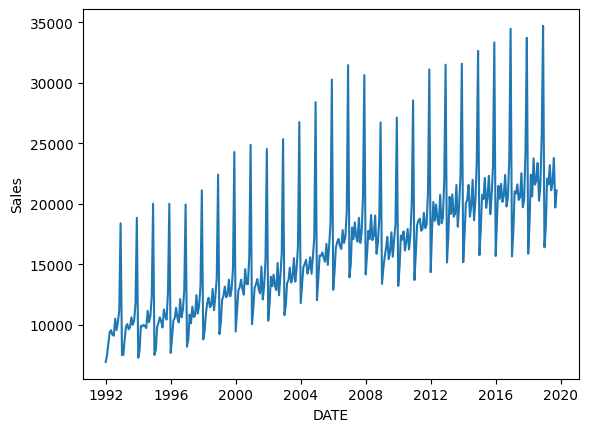

In [4]:
sns.lineplot(x = matrix_data.index, y = matrix_data["Sales"])

In [5]:
#we want to have at least one and a half years of training on the data
train = matrix_data.iloc[:-24]
test = matrix_data[-24 :]

In [6]:
mm_scaler = MinMaxScaler()
scaled_train = mm_scaler.fit_transform(train)
scaled_test = mm_scaler.transform(test)

In [7]:
batch_length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = batch_length, batch_size = 1)

In [8]:
feature, label = generator[0]

In [9]:
learner = Sequential()
learner.add(LSTM(200, activation = "relu"))
learner.add(Dense(1))
learner.compile(optimizer = "adam", loss = "mse")

In [10]:
stopper = EarlyStopping(patience = 4)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = batch_length, batch_size = 1)

In [11]:
learner.fit(generator, validation_data = validation_generator, epochs = 20, callbacks = [stopper])

Epoch 1/20
298/298 [==============================] - 4s 7ms/step - loss: 0.0201 - val_loss: 0.0187
Epoch 2/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0113 - val_loss: 0.0036
Epoch 3/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0037 - val_loss: 0.0062
Epoch 4/20
298/298 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 8.7011e-04
Epoch 5/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 7.0686e-04
Epoch 8/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0118
Epoch 9/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 10/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss

<Axes: >

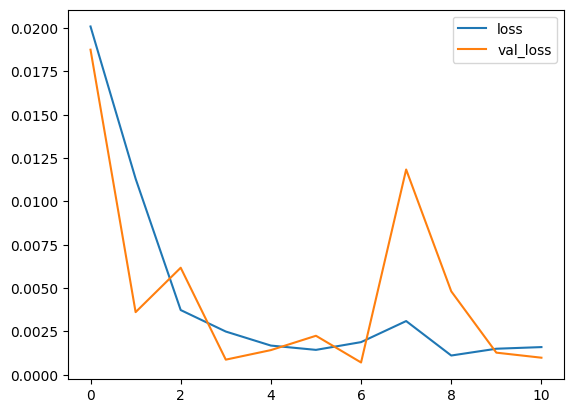

In [12]:
losses = pan.DataFrame(learner.history.history)
losses.plot()

In [13]:
#testing the data
def get_predictions(steps , train_data, tf_learner, batch_length) -> list[float]:
    predictions = []
    train_batch = train_data[-batch_length:].reshape((1, batch_length, 1))
    for i in range(steps):
        curr = tf_learner.predict(train_batch)[0]
        predictions.append(curr)
        train_batch = np.append(train_batch[:, 1:, :], [[curr]], axis = 1)
    return predictions
predictions = get_predictions(steps = len(scaled_test), batch_length = batch_length, train_data = scaled_train, tf_learner = learner)

1/1 [==============================] - 0s 20ms/step


In [14]:
predictions = mm_scaler.inverse_transform(predictions)
test["predictions"] = predictions

C:\Users\omoke\AppData\Local\Temp\ipykernel_9296\1550553896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = predictions


<Axes: xlabel='DATE'>

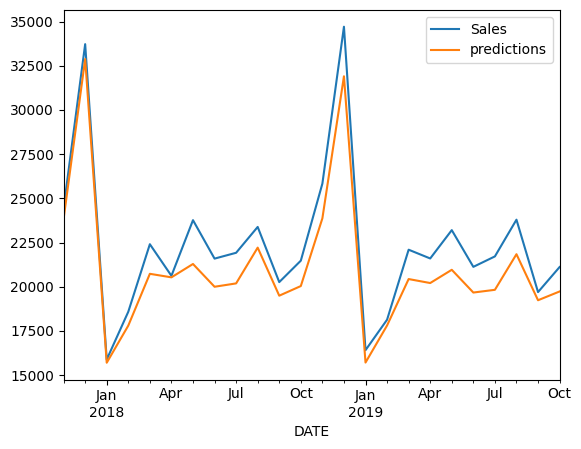

In [15]:
test.plot()

In [18]:
total_scaler = MinMaxScaler()
full_data = total_scaler.fit_transform(matrix_data)
length = 12
new_gen = TimeseriesGenerator(full_data, full_data, length = length, batch_size = 1)

In [22]:
total_learner = Sequential()
total_learner.add(LSTM(units = 200, activation = "relu", input_shape = (length, 1)))
total_learner.add(Dense(units = 128, activation = "relu"))
total_learner.add(Dense(1))
total_learner.compile(optimizer = "adam", loss = "mse")

In [23]:
total_learner.fit(new_gen, epochs = 11)

Epoch 1/11
322/322 [==============================] - 4s 6ms/step - loss: 0.0253
Epoch 2/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0156
Epoch 3/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0059
Epoch 4/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0060
Epoch 5/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 6/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 7/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 8/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 9/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 10/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 11/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0017


In [25]:
forecast = get_predictions(steps = 16, train_data = full_data, batch_length = 12, tf_learner = total_learner)

1/1 [==============================] - 0s 25ms/step


In [26]:
forecast = total_scaler.inverse_transform(forecast)

In [28]:
forecast_index = pan.date_range(start = "2019-11-01", periods = 16, freq = "MS")

In [30]:
forecasts = pan.DataFrame(columns = ["Forecast"], index = forecast_index, data = forecast)

<Axes: xlabel='DATE'>

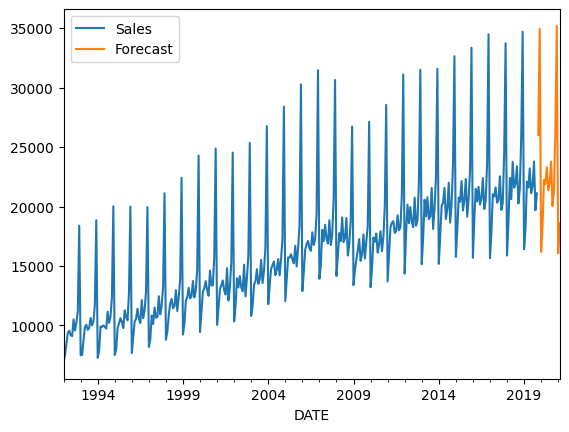

In [33]:
ax = matrix_data.plot()
forecasts.plot(ax = ax)